In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
def plot_pcs(data, axes, title='', color='blue'):
    eigvals, eigvecs = np.linalg.eigh(data.cov())
    data = np.dot(eigvecs, data.T).T
    data = pd.DataFrame(data)
    ax = data.plot.scatter(ax=axes, x=0, y=1, title=title, color=color);
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2');

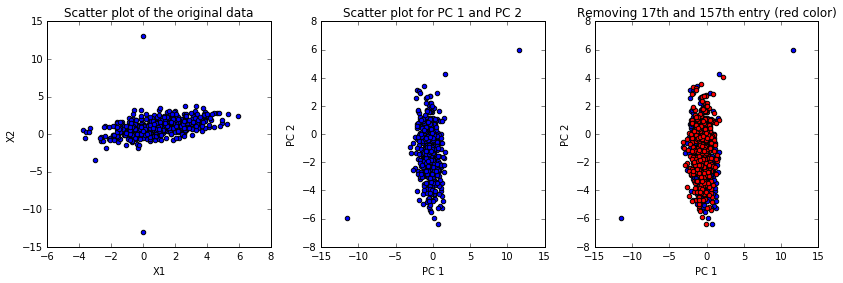

In [4]:
# Exercise 4.1
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

orig_data = pd.read_csv("pca2.csv")
orig_data.plot.scatter(ax=axes[0], x=0, y=1, title='Scatter plot of the original data')

# Transform into the coordinate system of the PCAs
plot_pcs(orig_data, axes[1], 'Scatter plot for PC 1 and PC 2')
# TODO What do you observe?

changed_data = orig_data.drop([16, 156])
plot_pcs(orig_data, axes[2], 'Removing 17th and 157th entry (red color)', color='blue')
plot_pcs(changed_data, axes[2], color='red')
# TODO What is the difference?

figure.tight_layout()

In [5]:
def remove_outliers(data, dim):
    centered = data[:, dim] - np.mean(data[:, dim])
    std = np.std(centered)
    selection = np.abs(centered) <= 2.45 * std
    return data[selection]

# 2.3(d)
def scree_plot(data, ax, row, col):
    eigvals, eigvecs = np.linalg.eigh(np.cov(data.T))
    data = np.dot(eigvecs, data.T).T
    data = pd.DataFrame(data)
    
    sing_vals = np.arange(len(eigvals)) + 1
    ax[row, col].plot(sing_vals, eigvals[::-1], 'ro-', linewidth=2)
    ax[row, col].set_title('Scree plot')
    ax[row, col].set_xlabel('Principal Component')
    ax[row, col].set_ylabel('Eigenvalue')

def projection(data):
    _, pcs = np.linalg.eigh(np.cov(data.T))
    return np.dot(pcs,data.T).T

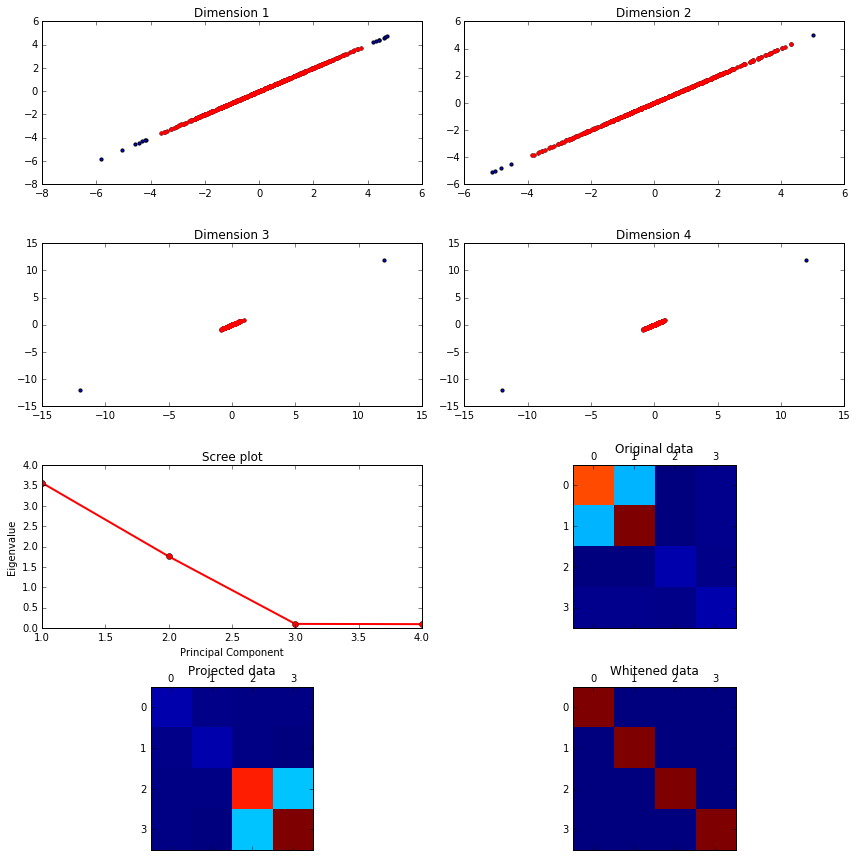

In [6]:
# Exercise 4.2(a)
data = pd.read_csv("pca4.csv").as_matrix()
dimensions = data.shape[1]
figure, axes = plt.subplots(nrows=dimensions, ncols=2, figsize=(12, 12))

for dim in range(dimensions):
    axes[dim // 2, dim % 2].scatter(x=data[:,dim], y=data[:,dim], s=10)
    axes[dim // 2, dim % 2].set_title('Dimension {}'.format(dim + 1))
    data = remove_outliers(data, dim)
    axes[dim // 2, dim % 2].scatter(x=data[:,dim], y=data[:,dim], color='red', s=8)

# Exercise 4.2(b) -> Result: Only take the first two PCs
scree_plot(data, axes, 2, 0)

# Exercise 4.2(c)
data -= np.mean(data)
covmat = np.cov(data.T)
eigvals, eigvecs = np.linalg.eigh(covmat)
E = eigvecs[::]
D = np.diag(eigvals[::])

Z = np.dot(np.dot(data, E), np.linalg.inv(np.sqrt(D)))

# Exercise 4.2(d)
axes[2, 1].matshow(covmat)
axes[2, 1].set_title('Original data')
covmat = np.cov(projection(data).T)
axes[3, 0].matshow(covmat)
axes[3, 0].set_title('Projected data')
covmat = np.cov(Z.T)
axes[3, 1].matshow(covmat)
axes[3, 1].set_title('Whitened data')

figure.tight_layout()

In [7]:
def create_sample_points(number, x_mean, y_mean, std=0.1):
    return np.array([[random.gauss(x_mean, std), random.gauss(y_mean, std)]
                   for _ in range(number)])

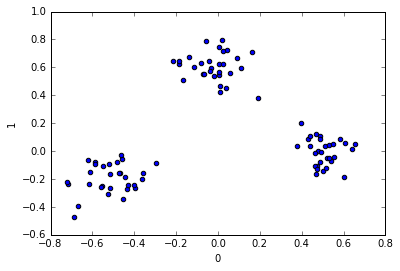

In [8]:
x = create_sample_points(30, -0.5, -0.2)
y = create_sample_points(30, 0, 0.6)
z = create_sample_points(30, 0.5, 0)
data = np.concatenate((x, y, z), axis=0)
pd.DataFrame(data).plot.scatter(x=0, y=1)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Amount of positive eigenvalues: 43


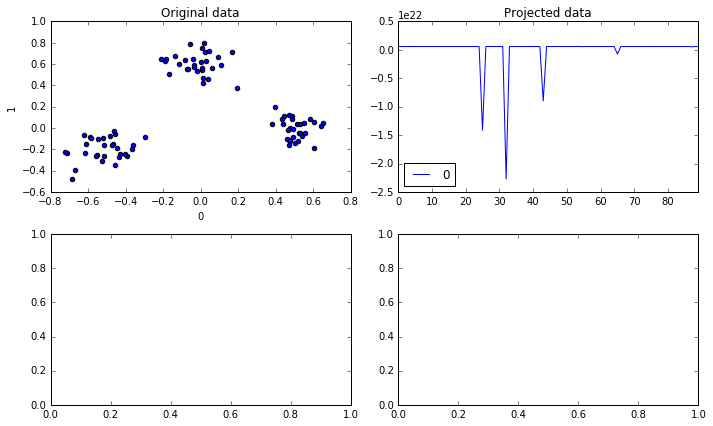

In [88]:
def rbf_kernel(x, y, sigma):
    len_difference = np.sqrt((x - y).dot((x - y)))  
    return np.exp(len_difference ** 2 / (2 * sigma ** 2)) 

def calculate_kernel_matrix(data, sigma):
    order = len(data)
    kernel = np.empty((order, order))
    for idx1, first in enumerate(data):
        for idx2, second in enumerate(data):
            kernel[idx1][idx2] = rbf_kernel(first, second, sigma)
    return kernel

def normalize_kernel_matrix(kernel):
    overall_mean = np.mean(kernel)
    sums = np.sum(kernel, axis=0)
    s = kernel.shape
    p = kernel.shape[0]
    kernel_n = np.empty(s)
    for a, b in np.ndindex(s):
        kernel_n[a, b] = kernel[a, b] - sums[a] / p - sums[b] / p + overall_mean / (p ** 2)
    return kernel_n

def plot_kernel_projection(kernel, axes, title):
    _, eigvecs = np.linalg.eigh(kernel)
    transformed = np.dot(eigvecs, kernel)
    pd.DataFrame(transformed).plot.scatter(x=0, y=1, ax=axes, title=title)

def normalized_eigvecs(kernel):
    p = kernel.shape[0]
    eigvals, eigvecs = np.linalg.eigh(kernel)
    eigvals = eigvals[::-1] / p
    eigvecs = eigvecs[::-1]
    norm_eigvecs = np.zeros((p, p))
    for i in range(len(eigvecs)):
        if eigvals[i] <= 0:
            break;
        norm_eigvecs[i] = eigvecs[i] / (np.sqrt(p * eigvals[i]) * np.linalg.norm(eigvecs[i]))
    # Select all vectors which values all equals zero
    print('Amount of positive eigenvalues: {}'.format(len(eigvals[eigvals>0])))
    return eigvals, norm_eigvecs

def calculate_projections(eigvecs, kernel, k=0):
    # TODO: Fix this
    p = kernel.shape[0]
    x = np.zeros(p)
    for a in range(p):
        for b in range(p):
            x[a] += eigvecs[k, b] * kernel[b, a]
    return x

first_eigvec = np.linalg.eigh(np.cov(data))[1][-1]
kernel = calculate_kernel_matrix(data, 0.1)
kernel = normalize_kernel_matrix(kernel)
eigvals, eigvecs = normalized_eigvecs(kernel)
transformed = calculate_projections(eigvecs, kernel)

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
pd.DataFrame(data).plot.scatter(x=0, y=1, ax=axes[0, 0], title='Original data')
pd.DataFrame(transformed).plot(ax=axes[0, 1], title='Projected data')
# plot_kernel_projection(kernel, axes[0, 1], 'Transformed by PCs of the kernel matrix')
figure.tight_layout()
